In [1]:
from __future__ import division, print_function
%matplotlib inline
import sys
sys.path.insert(0,'..') # allow us to format the book
sys.path.insert(0,'../code') 
# use same formatting as rest of book so that the plots are
# consistant with that look and feel.
import book_format
book_format.load_style(directory='..')

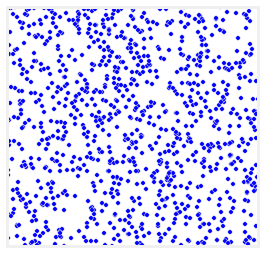

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from random import uniform
import matplotlib.pylab as pylab
from matplotlib import animation
from gif_animate import animate
import matplotlib as mpl
from math import pi

def make_particle():
    return  [uniform(0,100), uniform(0,100), uniform(0, 2), uniform(0, 2*pi)]


def move(particles, t=1.):
    vx = particles[:, 2]*np.cos(particles[:, 3])
    vy = particles[:, 2]*np.sin(particles[:, 3])
    particles[:, 0] = (particles[:, 0] + vx*t) % 100
    particles[:, 1] = (particles[:, 1] + vy*t) % 100
        
particles = np.asarray([make_particle() for i in range(1000)])

def panimate(frame):
    move(particles, t=1.)

    plt.cla()
    plt.scatter(particles[:, 0], particles[:, 1])
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])

    
animate('13_particle_move.gif', panimate, 
        frames=500, interval=50, figsize=(4, 4))

<img src='13_particle_move.gif'>